In [1]:
import os

train_test_split = ['train', 'test', 'val']
categories = ['NORMAL', 'PNEUMONIA']
directory = '/kaggle/input/chest-xray-pneumonia/chest_xray'

for entry in train_test_split:
    full_path = os.path.join(directory, entry)
    if os.path.isdir(full_path):
        print("Folder:", full_path)

Folder: /kaggle/input/chest-xray-pneumonia/chest_xray/train
Folder: /kaggle/input/chest-xray-pneumonia/chest_xray/test
Folder: /kaggle/input/chest-xray-pneumonia/chest_xray/val


In [2]:
import numpy as np
from PIL import Image

xlabels = []
yvalues = []

for ttv in train_test_split:
    train_test_split_count = 0
    for category in categories:
        category_count = 0
        folder_path = os.path.join(directory, ttv, category)
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            image = Image.open(image_path)
            nparray_image = np.array(image)
            
            category_count += 1
        train_test_split_count += category_count

        xlabels.append(ttv + category)
        yvalues.append(category_count)
        
        print(f"For {ttv}, image count for {category} is {train_test_split_count}")
    print(f"For {ttv} image count is {train_test_split_count}")

For train, image count for NORMAL is 1341
For train, image count for PNEUMONIA is 5216
For train image count is 5216
For test, image count for NORMAL is 234
For test, image count for PNEUMONIA is 624
For test image count is 624
For val, image count for NORMAL is 8
For val, image count for PNEUMONIA is 16
For val image count is 16


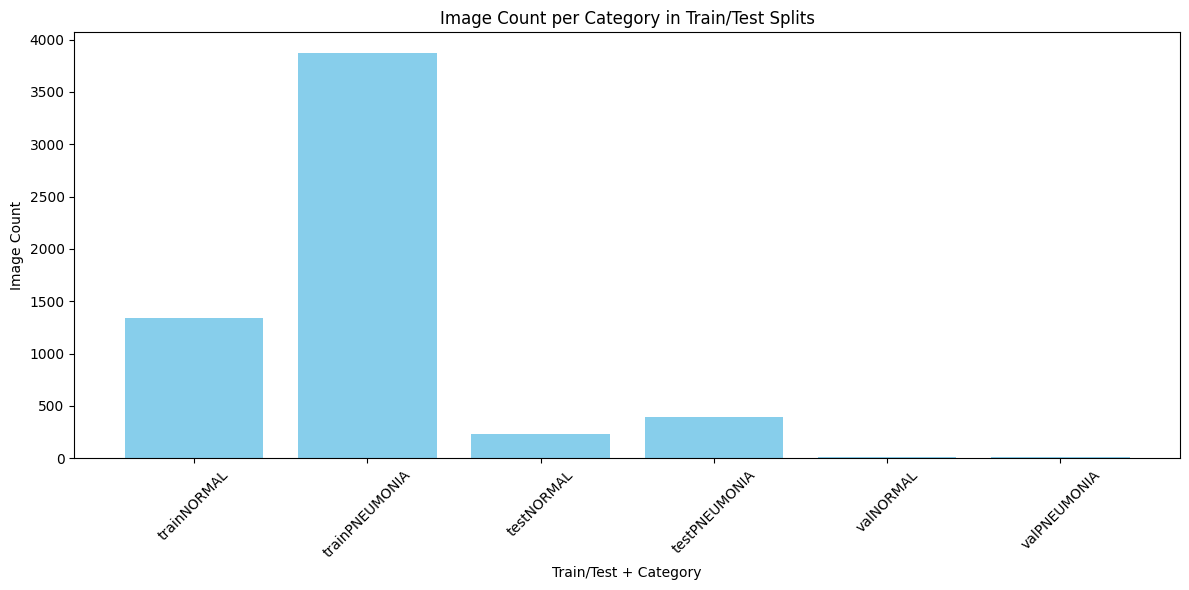

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(xlabels, yvalues, color='skyblue')
plt.xlabel("Train/Test + Category")
plt.ylabel("Image Count")
plt.title("Image Count per Category in Train/Test Splits")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
import numpy as np
from PIL import Image

dimentions_count = {}
total_images = 0

for ttv in train_test_split:
    for category in categories:
        folder_path = os.path.join(directory, ttv, category)
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)

            image = Image.open(image_path)
            nparray_image = np.array(image)
            dimentions_count[nparray_image.shape] = dimentions_count.get(nparray_image.shape, 0) + 1
            total_images += 1

In [5]:
print(len(dimentions_count))

4803


In [6]:
print(total_images)

5856


In [7]:
mode_dimention_frequency = 0
mode_dimention = None
for dims, frequencty in dimentions_count.items():
    if mode_dimention_frequency < frequencty:
        mode_dimention_frequency = frequencty
        mode_dimention = dims

In [8]:
print(f"Mode dimention is {mode_dimention} with frequency {mode_dimention_frequency}")

Mode dimention is (648, 1072) with frequency 7


Compared to 5856, 7 is very low number.

In [9]:
output_directory_resized = "/kaggle/working/resized_images_224"
os.makedirs(output_directory_resized, exist_ok=True)

In [10]:
import os
from PIL import Image

def resize_with_padding(image, target_size):
    """
    Resizes an image while maintaining aspect ratio, then adds black padding to match the target size.
    """
    img_ratio = image.width / image.height
    target_ratio = target_size[0] / target_size[1]

    if img_ratio > target_ratio:

        new_width = target_size[0]
        new_height = round(new_width / img_ratio)
    else:
        new_height = target_size[1]
        new_width = round(new_height * img_ratio)

    img_resized = image.resize((new_width, new_height), Image.LANCZOS)

    new_image = Image.new("RGB", target_size, (0, 0, 0))
    new_image.paste(img_resized, ((target_size[0] - new_width) // 2, (target_size[1] - new_height) // 2))

    return new_image

def resize_images_for_transfer_learning(size):
    """
    Resizes images to a fixed size with black padding and preserves the original dataset structure.
    """
    PATH_I = '/kaggle/input/chest-xray-pneumonia/chest_xray'
    PATH_O = f'/kaggle/working/chest_xray_resized_{size}'

    train_test_split = ['train', 'val', 'test']
    categories = ['NORMAL', 'PNEUMONIA']

    for split in train_test_split:
        for category in categories:
            os.makedirs(os.path.join(PATH_O, split, category), exist_ok=True)

    for split in train_test_split:
        for category in categories:
            input_dir = os.path.join(PATH_I, split, category)
            output_dir = os.path.join(PATH_O, split, category)

            if not os.path.isdir(input_dir):
                continue  

            for file in os.listdir(input_dir):
                img_path = os.path.join(input_dir, file)
                
                try:
                    img = Image.open(img_path).convert('L')

                    img = img.convert("RGB")

                    img_resized = resize_with_padding(img, (size, size))

                    output_path = os.path.join(output_dir, file)
                    img_resized.save(output_path)


                except Exception as e:
                    print(f"Failed to process {img_path}: {e}")

resize_images_for_transfer_learning(224)


In [11]:
import os
import shutil
import random

source_dir = "/kaggle/working/chest_xray_resized_224/train"
target_dir = "/kaggle/working/chest_xray_resized_224/train_balanced"

class_names = ["NORMAL", "PNEUMONIA"]

for class_name in class_names:
    class_path = os.path.join(target_dir, class_name)
    os.makedirs(class_path, exist_ok=True)

image_counts = {}
for class_name in class_names:
    class_path = os.path.join(source_dir, class_name)
    image_counts[class_name] = len(os.listdir(class_path))
    
print("Original image counts per class:", image_counts)

min_count = min(image_counts.values())
print(f"Balancing all classes to {min_count} images.")

for class_name in class_names:
    src_path = os.path.join(source_dir, class_name)
    dst_path = os.path.join(target_dir, class_name)

    all_images = os.listdir(src_path)
    random.shuffle(all_images)
    selected_images = all_images[:min_count]

    for image_name in selected_images:
        src_file = os.path.join(src_path, image_name)
        dst_file = os.path.join(dst_path, image_name)
        shutil.copy2(src_file, dst_file)

print(f"\nBalanced dataset created at: {target_dir}")


Original image counts per class: {'NORMAL': 1341, 'PNEUMONIA': 3875}
Balancing all classes to 1341 images.

✅ Balanced dataset created at: /kaggle/working/chest_xray_resized_224/train_balanced


In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

dataset_path = "/kaggle/working/chest_xray_resized_224"


IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train_balanced"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary", 
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_path, "train_balanced"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_path, "test"),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)


Found 2146 images belonging to 2 classes.
Found 536 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [13]:
print(f"Number of training images: {train_generator.n}")
print(f"Number of validation images: {val_generator.n}")
print(f"Number of test images: {test_generator.n}")

Number of training images: 2146
Number of validation images: 536
Number of test images: 624


In [20]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def build_custom_cnn(input_shape, num_classes):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

def build_transfer_model(base_model_class, input_shape, num_classes=1):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False  

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=output)
    return model


def evaluate_model_with_metrics(model, test_generator, model_name):
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)


    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    print(f"\n--- Evaluation Debug for {model_name} ---")
    print("Sample predicted probabilities:", y_pred_probs[:5].flatten())
    print("Predicted labels:", y_pred[:5])
    print("True labels:", y_true[:5])

    accuracy = model.evaluate(test_generator, verbose=0)[1] * 100
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    return {
        "Model Name": model_name,
        "Accuracy (%)": round(accuracy, 2),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1 Score": round(f1, 4)
    }


def plot_history(history, model_name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

input_shape = (224, 224, 3)
num_classes = 2
sample_model = build_custom_cnn(input_shape, num_classes)
print(sample_model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

None


In [21]:
from sklearn.utils import class_weight
import numpy as np

train_labels = train_generator.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = dict(enumerate(class_weights))
print("Computed class weights:", class_weights)

Computed class weights: {0: 1.0, 1: 1.0}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📦 Training Custom CNN...
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 429ms/step - accuracy: 0.7140 - loss: 0.6277 - val_accuracy: 0.8713 - val_loss: 0.3278
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 411ms/step - accuracy: 0.8776 - loss: 0.2991 - val_accuracy: 0.8769 - val_loss: 0.2805
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 409ms/step - accuracy: 0.8978 - loss: 0.2600 - val_accuracy: 0.9123 - val_loss: 0.2373
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 422ms/step - accuracy: 0.9161 - loss: 0.2099 - val_accuracy: 0.9123 - val_loss: 0.2059
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 419ms/step - accuracy: 0.9130 - loss: 0.2174 - val_accuracy: 0.9142 - val_loss: 0.2066
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 416ms/step - accuracy: 0.9231 - loss: 0.1917 - val_accuracy: 0.9347 - val_loss: 0.1855
Epoch 7/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 31s 414ms/step - accuracy: 0.9377 - loss: 0.1558 - val_accuracy: 0.9235 - val_loss: 0.1872
Epoch 8/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 406ms/step - accuracy: 0.9290

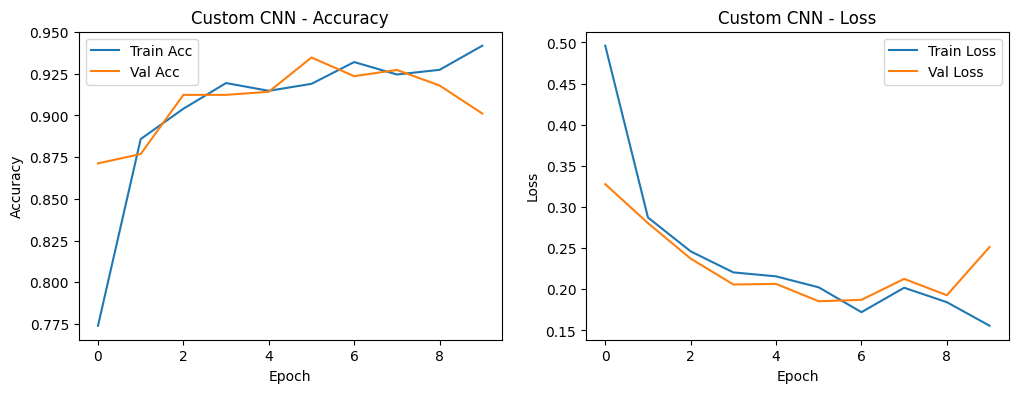

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

--- Evaluation Debug for Custom CNN ---
Sample predicted probabilities: [0.02946269 0.4242303  0.08932718 0.50038654 0.01606473]
Predicted labels: [0 0 0 1 0]
True labels: [0 0 0 0 0]

📦 Training VGG16...
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 33s 413ms/step - accuracy: 0.5421 - loss: 0.7031 - val_accuracy: 0.8172 - val_loss: 0.6389
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 381ms/step - accuracy: 0.6565 - loss: 0.6387 - val_accuracy: 0.8116 - val_loss: 0.5861
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 368ms/step - accuracy: 0.7569 - loss: 0.5743 - val_accuracy: 0.8358 - val_loss: 0.5403
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 372ms/step - accuracy: 0.7892 - loss: 0.5414 - val_accuracy: 0.8321 - val_loss: 0.5062
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 390ms/step - accuracy: 0.7992 - loss: 0.5100 - val_accuracy: 0.8228 - val_loss: 0.4739
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 398ms/step - accuracy: 0.8098 - loss: 0.4839 - val_accuracy: 0.8377

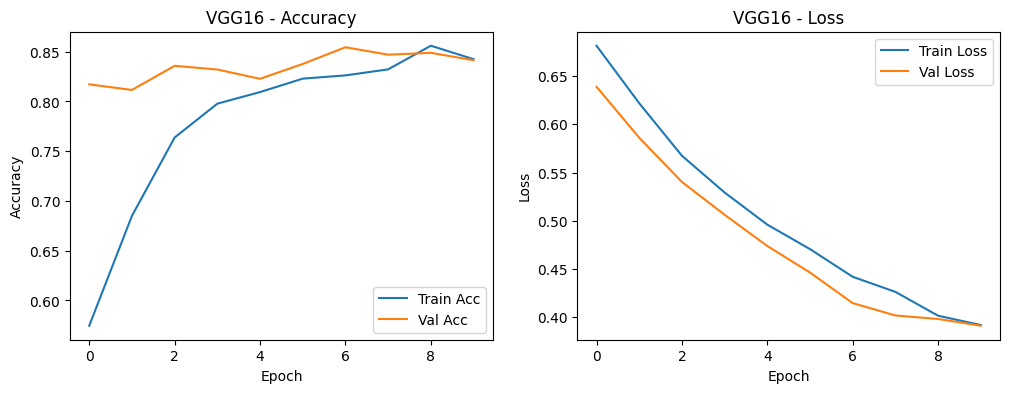

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step

--- Evaluation Debug for VGG16 ---
Sample predicted probabilities: [0.5788443  0.49234492 0.19528598 0.44692248 0.15558015]
Predicted labels: [1 0 0 0 0]
True labels: [0 0 0 0 0]

📦 Training ResNet18...
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 47s 496ms/step - accuracy: 0.5139 - loss: 0.7552 - val_accuracy: 0.5149 - val_loss: 0.6860
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 372ms/step - accuracy: 0.4908 - loss: 0.7222 - val_accuracy: 0.5541 - val_loss: 0.6771
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 394ms/step - accuracy: 0.5345 - loss: 0.6981 - val_accuracy: 0.5019 - val_loss: 0.6783
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 375ms/step - accuracy: 0.5403 - loss: 0.6950 - val_accuracy: 0.7649 - val_loss: 0.6622
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 376ms/step - accuracy: 0.5609 - loss: 0.6807 - val_accuracy: 0.5597 - val_loss: 0.6584
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 376ms/step - accuracy: 0.5786 - loss: 0.6735 - val_accuracy: 0.7854 -

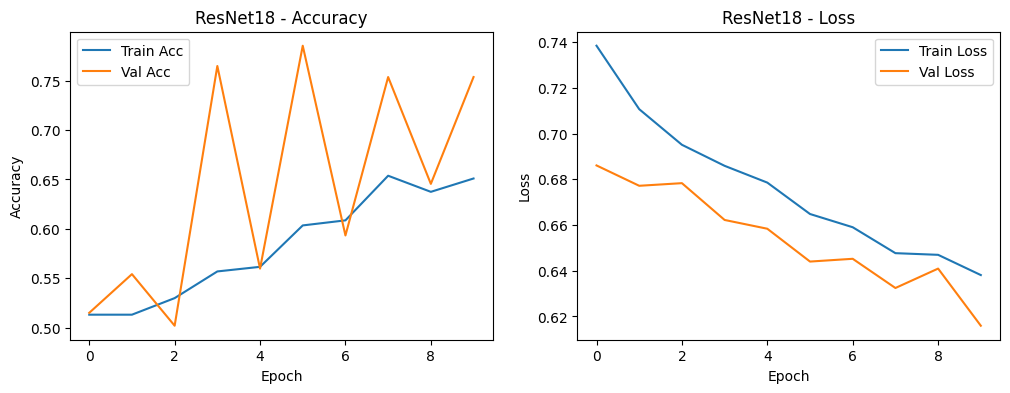

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step

--- Evaluation Debug for ResNet18 ---
Sample predicted probabilities: [0.45848757 0.4241728  0.3967161  0.47482738 0.42773488]
Predicted labels: [0 0 0 0 0]
True labels: [0 0 0 0 0]

📦 Training DenseNet121...
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 62s 601ms/step - accuracy: 0.5785 - loss: 0.7576 - val_accuracy: 0.8881 - val_loss: 0.3890
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 370ms/step - accuracy: 0.7731 - loss: 0.4685 - val_accuracy: 0.9086 - val_loss: 0.2916
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 366ms/step - accuracy: 0.8440 - loss: 0.3778 - val_accuracy: 0.9049 - val_loss: 0.2561
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 361ms/step - accuracy: 0.8706 - loss: 0.3130 - val_accuracy: 0.9310 - val_loss: 0.2148
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 358ms/step - accuracy: 0.9016 - loss: 0.2628 - val_accuracy: 0.9179 - val_loss: 0.2124
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 360ms/step - accuracy: 0.8976 - loss: 0.2540 - val_accuracy: 0

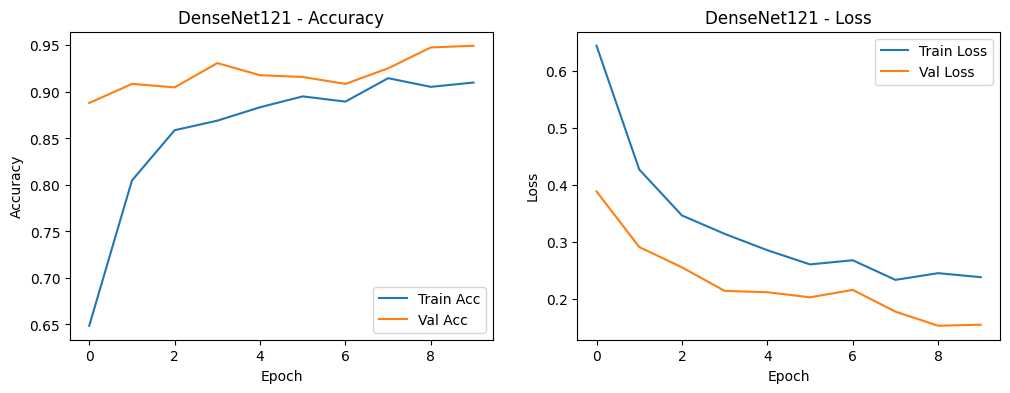

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 389ms/step

--- Evaluation Debug for DenseNet121 ---
Sample predicted probabilities: [0.8347439  0.22273381 0.6484627  0.4220231  0.44719103]
Predicted labels: [1 0 1 0 0]
True labels: [0 0 0 0 0]

📦 Training EfficientNetB0...
Epoch 1/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 56s 540ms/step - accuracy: 0.5203 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 2/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 353ms/step - accuracy: 0.4980 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 356ms/step - accuracy: 0.4599 - loss: 0.6945 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - accuracy: 0.5003 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 5/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 354ms/step - accuracy: 0.5051 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/10
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 355ms/step - accuracy: 0.4570 - loss: 0.6956 - val_accu

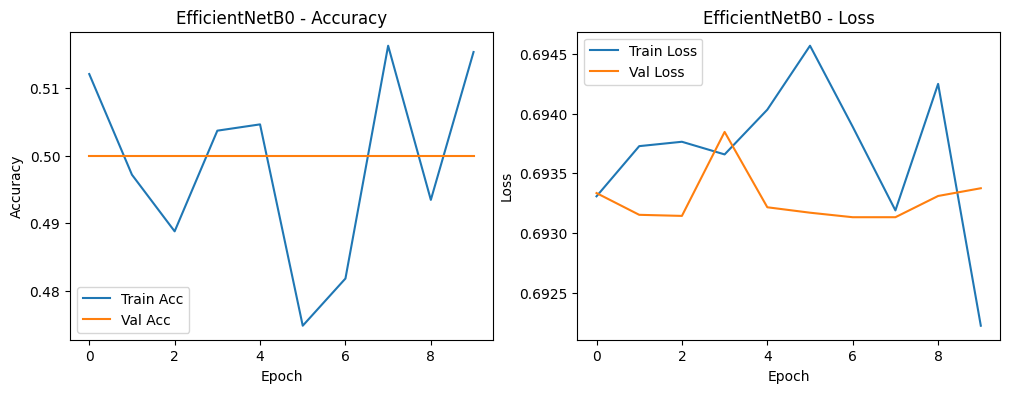

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step

--- Evaluation Debug for EfficientNetB0 ---
Sample predicted probabilities: [0.48888564 0.48887968 0.48880765 0.48878765 0.48883203]
Predicted labels: [0 0 0 0 0]
True labels: [0 0 0 0 0]


In [22]:
EPOCHS = 10
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

models_to_train = [
    ("Custom CNN", build_custom_cnn(input_shape, num_classes)),
    ("VGG16", build_transfer_model(VGG16, input_shape, num_classes)),
    ("ResNet18", build_transfer_model(ResNet50, input_shape, num_classes)), 
    ("DenseNet121", build_transfer_model(DenseNet121, input_shape, num_classes)),
    ("EfficientNetB0", build_transfer_model(EfficientNetB0, input_shape, num_classes))
]

results = []

for model_name, model in models_to_train:
    print(f"\n📦 Training {model_name}...")
    if model_name == "Custom CNN":
        learning_rate = 0.001
    else:
        learning_rate = 0.0001
    model.compile(optimizer=Adam(learning_rate= learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

    
    history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    verbose=1)


    plot_history(history, model_name)

    metrics = evaluate_model_with_metrics(model, test_generator, model_name)
    results.append(metrics)


In [24]:
df_results = pd.DataFrame(results)
print(df_results)


       Model Name  Accuracy (%)  Precision  Recall  F1 Score
0      Custom CNN         86.22     0.8615  0.8622    0.8617
1           VGG16         79.49     0.7935  0.7949    0.7894
2        ResNet18         69.23     0.7530  0.6923    0.6956
3     DenseNet121         82.37     0.8360  0.8237    0.8141
4  EfficientNetB0         37.50     0.1406  0.3750    0.2045
